# Analysis of the link between creative clustering and European referendum outcomes

### Hypothesis
There is a positive association between creative clustering and a TTWA's propensity to vote remain which is not fully explained by potential confounding factors like average levels of employment and education, or ethnic diversity.

### Data sources
* BSD: creative clustering (processed for the creative clusters report, available in the data folder)
* Electoral Commission: Referendum outcomes: 
[link](http://www.electoralcommission.org.uk/find-information-by-subject/elections-and-referendums/past-elections-and-referendums/eu-referendum/electorate-and-count-information) 
* ONS NOMIS: Control variables from Annual Population Survey, Census, Annual Business Survey. [link](https://www.nomisweb.co.uk/)

### Analytical process
1. Data collection:
 * Download Referendum data, ONS data
2. Data processing:
 * Convert data to suitable geography (TTWA, via lookups)
 * Generate measures
3. Data analysis:
 * Exploratory data analysis: Plots and bivariate correlation
 * Modelling
   * Spatial autocorrelation tests
   * Model
4. Report

## 0: Preamble

In [1]:
#Imports

#Directory management
import os
import sys

#Data download
from urllib.request import urlretrieve
from urllib.request import urlopen
import requests
import ratelim
import zipfile

#Data processing
import csv
import datetime
import re

#Data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import toyplot
import pysal


#Inline charts
%matplotlib inline

/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#Set directory etc.
work_dir = os.getcwd()
#Create output directories
if 'data' not in os.listdir():
    os.mkdir('data')
if 'data_outputs' not in os.listdir():
    os.mkdir('data_outputs')
if 'viz_outputs' not in os.listdir():
    os.mkdir('viz_outputs')

In [72]:
#Functions

#Create function that returns a conversion of stats in laua to ttwa.
def transform_la_to_ttwa(la_df,la_var,selected_vars):
    '''
    input: a df where one column (la_var) is the laua 
        and the rest (selected_vars list) are the stats to aggregate over
    output: df converting stats to TTWA.
    '''
    
    merged = pd.merge(laua_ttwa_lookup,
                     la_df,left_on='laua',right_on=la_var,how='inner')
    
    #Apply the weight to variables of interest
    weighted = merged[selected_vars].apply(lambda x: x*merged['value'])
    
    #TTWA variable
    weighted['ttwa'] = merged.ttwa
    
    #Aggregate over ttwas
    ttwa_results = weighted.groupby('ttwa')[selected_vars].apply(
        lambda x: x.sum()).reset_index(drop=False) 
    
    return(ttwa_results)

def transform_ashe_to_ttwa(ashe_df):
    '''
    Ashe allocation function takes a df with La/TTWA lookup and returns the weighted median of all
        #the LADs in a TTWA. There are missing values in ASHE for some LAds, in which case this
        returns NA.
    '''

    
    merged = pd.merge(ttwa_laua_distr,
                  ashe_laua_selected_df,left_on='laua',right_on='geography_code',how='inner')
    
    merged['weighted'] = merged['obs_value']*merged['value']
    

    #Aggregate over ttwas
    ttwa_results = merged.groupby('ttwa')['weighted'].apply(
        lambda x: get_weighted_mean(x)).reset_index(drop=False) 
    
    return(ttwa_results)

def get_weighted_mean(x):
    '''
    Input: a series
    Output: If the series contains a nan, nan. Otherwise, the mean of the values in the series.
    '''
    
    has_nan = any([np.isnan(i) for i in x])
    if has_nan==True:
        return np.nan
    else:
        return x.sum()
    
def log_normalise(var):
    '''
    input: a variable
    output: the log-normalised version
    
    '''    
    return(scipy.stats.mstats.zscore(np.log(var)))

def zscore(x):
    z = scipy.stats.mstats.zscore(x)
    return(z)

def winsorize(x,thres=0.01):
    '''
    input: x, a series.
    output: the same series, winsoried (values in the top and bottom x-tile are removed by the xtile)
    '''
    
    x_cop = x.copy()
    
    x_cop_bot = x_cop.quantile(thres)
    x_cop_top = x_cop.quantile(1-thres)

    x_cop[x_cop<x_cop_bot] = x_cop_bot
    x_cop[x_cop>x_cop_top] = x_cop_top
    
    return(x_cop)
    

## 1. Data collection

In [13]:
#1. Download referendum data
file_url = "http://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv"

#Read csv.
ref_result = pd.read_csv(file_url)

#Save csv
ref_result.to_csv("data/ref_result.csv")

In [9]:
#2. Download Nomis data
#APS data with employment and qualifications
aps_ttwa_url = "http://www.nomisweb.co.uk/api/v01/dataset/NM_17_5.data.csv?geography=1874853889...1874854100,1874854111...1874854116&date=latest&variable=MAKE|Economic%20activity%20rate%20-%20aged%2016-64|25|22,MAKE|Employment%20rate%20-%20aged%2016-64|28|22,MAKE|Unemployment%20rate%20-%20aged%2016-64%20|37|25,MAKE|%25%20with%20NVQ4%2B%20-%20aged%2016-64|1181|1176...1182,MAKE|%25%20with%20no%20qualifications%20(NVQ)%20-%20aged%2016-64|1176|1176...1182&measures=20599,21001,21002,21003&select=date_name,geography_name,geography_code,variable_name,measures_name,obs_value,obs_status_name"

#Read and save CSV
aps_ttwa_df = pd.read_csv(aps_ttwa_url)
aps_ttwa_df.to_csv("data/aps_ttwa.csv")

#For some reason there are issues with the APS data extraction. We load a saved file.
aps_ttwa_df = pd.read_csv("data/aps_ttwa_restored.csv")

#Census data with ethnicity
census_laua_url= "http://www.nomisweb.co.uk/api/v01/dataset/NM_682_1.data.csv?date=latest&geography=1946157057...1946157404&c_sex=0&c_age=0&c_nssec=0&c_ethpuk11=0,1,6,11,17,21&measures=20100&select=date_name,geography_name,geography_code,c_sex_name,c_age_name,c_nssec_name,c_ethpuk11_name,measures_name,obs_value,obs_status_name"
census_laua_df = pd.read_csv(census_laua_url)
census_laua_df.to_csv("data/census_laua.csv")

#ASHE data with annual earnings
ashe_data_url = "http://www.nomisweb.co.uk/api/v01/dataset/NM_30_1.data.csv?geography=1946157057...1946157436&date=latest&sex=8&item=2&pay=1,7&measures=20100,20701&select=date_name,geography_name,geography_code,sex_name,pay_name,item_name,measures_name,obs_value,obs_status_name"
ashe_laua_df = pd.read_csv(ashe_data_url)
ashe_laua_df.to_csv("data/ashe_laua_df.csv")

In [19]:
#Scottish census data
urlretrieve("http://www.scotlandscensus.gov.uk/ods-web/download/getDownloadFile.html?downloadFileIds=Council%20Area%20blk",
           "data/scottish_countil_area.zip")

#Unzip and load Scottish data file
zf = zipfile.ZipFile('data/scottish_countil_area.zip')
census_sc_df = pd.read_csv(zf.open('DC6206SC.csv'))
census_sc_df.to_csv("data/census_sc_df.csv")

In [4]:
#3. Read clusters data
creative_clusters = pd.read_csv("data/ttwa_for_vml-2016-06-15.csv")

In [5]:
#Lookup LA-Unitary - TTWA
#Download the NSPL here: https://ons.maps.arcgis.com/home/item.html?id=7484863a5e7b493a88b0de9aa65fe9d1
#Unzip and place the csv in the data folder.

nspl_df = pd.read_csv("data/NSPL_FEB_2016_UK.csv")

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Data processing

In [11]:
#We need to allocate LAUs to TTWAs.
#Create crosstab
laua_ttwa_lookup_table = pd.crosstab(nspl_df.ttwa,nspl_df.laua)

#Total LAUs
laua_props = laua_ttwa_lookup_table.sum(axis=0)

#In this df, each column presents the % of postcodes in a local authority in a TTWA.
#We also reset the index to convert ttwa into a variable (we will use it as an id in 
    #the next transformation)
laua_ttwa_lookup_prop = laua_ttwa_lookup_table.apply(lambda x: 
                                              x/laua_props,axis=1).reset_index(drop=False)

#Melt and remove rows where value = 0
laua_ttwa_lookup_melt = pd.melt(laua_ttwa_lookup_prop,id_vars="ttwa")
laua_ttwa_lookup = laua_ttwa_lookup_melt.ix[
    laua_ttwa_lookup_melt.value>0,].sort_values(by="ttwa").reset_index(drop=True)

#In laua_ttwa_lookup, values are the % of a LAUA activity that corresponds to a TTWA

In [14]:
#Obtain TTWA results for ref result_data
ref_results_ttwa = transform_la_to_ttwa(ref_result,'Area_Code',
                                       selected_vars=["Electorate","Remain","Leave"])


ref_results_ttwa.rename(columns={x : 'ref_'+x.lower() for x in ref_results_ttwa.columns[1:4]},
                       inplace=True)

In [15]:
#For ASHE earnings data
#Clean variable names
ashe_laua_df.columns = ashe_laua_df.columns.str.lower()
#Identify variables of interest
my_vars = ['geography_code','obs_value']

#Select variables of interest
ashe_laua_selected_df = ashe_laua_df.ix[
    (ashe_laua_df['measures_name']=="Value") & 
    (ashe_laua_df['pay_name']=="Annual pay - gross"),my_vars]


#We need to create a lookup table that gives us the distribution of LADs inside of a TTWA. This is
    #to produce weighted means of salaries in TTWAs
#Create modified laua_ttwa_lookup that only includes LADs that have ASHE data (we assume areas with no
    #ASHE data are small, data is NA due to non-disclosure arrangements)
lauas_with_ashe_data = [i for i
                        in laua_ttwa_lookup.laua if i in list(ashe_laua_selected_df.dropna().geography_code)]

#Subset the ttwa_table

laua_ttwa_lookup_table_for_ashe = laua_ttwa_lookup_table.ix[:,lauas_with_ashe_data]

#Total number of postcodes in a TTWA
ttwa_props = laua_ttwa_lookup_table_for_ashe.sum(axis=1)

#In this df, each column presents the % of postcodes in a LAD for each TTWA.
#We also reset the index to convert ttwa into a variable (we will use it as an id in 
    #the next transformation)
    
#We want to focus this only on those lauas for which we have ashe data.  
ttwa_laua_distr = laua_ttwa_lookup_table_for_ashe.apply(lambda x: 
                                              x/ttwa_props,axis=0).reset_index(drop=False)

#Melt and remove rows where value = 0
ttwa_laua_distr_melt = pd.melt(ttwa_laua_distr,id_vars="ttwa")
ttwa_laua_distr = ttwa_laua_distr_melt.ix[
    ttwa_laua_distr_melt.value>0,].sort_values(by="ttwa").reset_index(drop=True)


In [16]:
#TTWA Lookup
ashe_ttwa = transform_ashe_to_ttwa(ashe_laua_selected_df)

ashe_ttwa.rename(columns={'weighted':'ashe_annual_pay_gross'},inplace=True)

In [17]:
#For census diversity data
#We want to combine the EW and Scotland data.

#Process England
census_ew_vars = ['GEOGRAPHY_CODE','C_ETHPUK11_NAME','OBS_VALUE']

census_laua_df2 = census_laua_df[census_ew_vars]

census_laua_df2.rename(columns={'GEOGRAPHY_CODE':'lad_code',
                              'C_ETHPUK11_NAME': 'ethn_stats',
                              'OBS_VALUE':'value'},inplace=True)

census_ew_wide = pd.pivot_table(census_laua_df2,
                               index='lad_code',
                               columns='ethn_stats',values='value').reset_index(drop=False)

#Non-white measure
census_ew_wide['census_non_white'] = census_ew_wide[
    'All categories: Ethnic group']- census_ew_wide['White: Total']

census_ew_wide.rename(columns={'All categories: Ethnic group':'census_total',
                              'White: Total':'census_white'},inplace=True)

#Final subset
census_ew_df = census_ew_wide[['lad_code','census_total','census_white','census_non_white']]

census_ew_df.columns.name=None

/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [20]:
#Process Scotland
#Focus on totals
census_sc_df2 = census_sc_df.ix[(census_sc_df['Unnamed: 2']=="Total") &
                                (census_sc_df['Unnamed: 1']=="All people aged 16 to 74:"),:]

#Rename variables
census_sc_df2.rename(columns={'Unnamed: 0':'area_code',
                               'Unnamed: 1':'age',
                               'Unnamed: 2':'occupation'},inplace=True)

#Filter out non-LA areas ('councils')
councils = [a in list(laua_ttwa_lookup['laua']) for a in census_sc_df2['area_code']]

#Subset by relevant variables
selected_sc_vars = census_sc_df2.columns[[0]+list(range(3,10))]

census_sc_df2 = census_sc_df2.ix[councils,selected_sc_vars]

#Focus on white/non_white/total
census_sc_df2['census_non_white'] = census_sc_df2[
    'All people aged 16 to 74']- census_sc_df2['White']

census_sc_df2.rename(columns={
        'area_code':'lad_code',
        'All people aged 16 to 74':'census_total',
        'White':'census_white'},inplace=True)

census_scot_df = census_sc_df2[['lad_code','census_total','census_white','census_non_white']]

/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [21]:
census_lad_df = pd.concat([census_ew_df,census_scot_df],axis=0)

#Convert to ttwa
census_ttwa_df = transform_la_to_ttwa(census_lad_df,'lad_code',
                                      ['census_total','census_white','census_non_white'])

In [22]:
all_transformed_df = pd.merge(pd.merge(ref_results_ttwa,
                                  census_ttwa_df,
                                  left_on="ttwa",right_on='ttwa',how='outer'),
                              ashe_ttwa,
                              left_on='ttwa',right_on='ttwa',how='outer')
                                   

In [23]:
#Merge ref results ttwa with other dfs.

#A. Process APS data
#Lowercase column names
aps_ttwa_df.columns = aps_ttwa_df.columns.str.lower()

#Select variables
my_vars = ['geography_name','geography_code','variable_name','obs_value']

#Subset dataframe
aps_df = aps_ttwa_df.ix[aps_ttwa_df.measures_name=="Variable",my_vars]

#Reshape
aps_wide = pd.pivot_table(aps_df,index=["geography_name","geography_code"],
               columns="variable_name",values="obs_value").reset_index(drop=False)

#Rename columns
aps_wide.columns = ['ttwa_name','ttwa_code','aps_nvq4_pc','aps_no_qual_pc',
                    'aps_econ_rate_pc','aps_emp_rate_pc','aps_unemp_rate_pc']

#B. Process Clusters data
#Variables of interest
cluster_vars = ['ttwa.name','TTWA11CD','variable','value']

#Select variables of interest
vars = [x in ['emp_lq','business_lq','business.count',"employment"] for x in creative_clusters.variable]
ind_var = creative_clusters.industry == "All creative industries"

#Subset dataframe
clusters = creative_clusters.ix[[x and y for x,y in zip(vars,ind_var)],cluster_vars]

#Reshape
clusters_wide = pd.pivot_table(clusters,index=['ttwa.name','TTWA11CD'],
                              columns='variable',values='value').reset_index(drop=False)

#Rename columns
clusters_wide.columns = ['ttwa_name','ttwa_code','ci_biz','ci_biz_lq',"ci_emp_lq",'ci_employment']

In [24]:
#Merge the three files
#Load ttwa-region lookup
ttwa_region_lu = pd.read_csv("data/ttwa_region_lookup.csv")


data_messy = pd.merge(pd.merge(all_transformed_df,
                pd.merge(aps_wide,clusters_wide,
                        left_on="ttwa_code",right_on="ttwa_code"),
               left_on="ttwa",
               right_on="ttwa_code",how="outer"),ttwa_region_lu,
                      left_on="ttwa_name_x",right_on="ttwa.name",how="outer")

keep_vars = ['ttwa_name_x','ttwa',"region",
             'ref_electorate','ref_remain','ref_leave',
             'census_total','census_white','census_non_white',
             'ashe_annual_pay_gross',
             'aps_nvq4_pc','aps_no_qual_pc', 
             'aps_econ_rate_pc','aps_emp_rate_pc','aps_unemp_rate_pc',
             'ci_biz','ci_biz_lq',"ci_emp_lq",'ci_employment']

#Subset
data = data_messy[keep_vars]

#Rename variables
data.rename(columns={"ttwa_name_x": "ttwa_name",
                    "ttwa": "ttwa_code",
                    },inplace=True)

#data = data[[data.region!="Northern Ireland"]]

/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


## 3: Descriptive stats and correlations

In [25]:
#Produce some new variables
data.ix[:,'remain_pc'] = data.ix[:,'ref_remain']/data.ix[:,'ref_leave']
data.ix[:,'non_white_pc'] = data.ix[:,'census_non_white']/data.ix[:,'census_total']

data['voted'] = data['ref_remain'] + data['ref_leave']
data['remain_rate'] = data['ref_remain']/data['voted']
data['leave_rate'] = data['ref_leave']/data['voted']



num_vars = ['ashe_annual_pay_gross', 'aps_nvq4_pc', 'aps_no_qual_pc',
       'aps_econ_rate_pc', 'aps_emp_rate_pc', 'aps_unemp_rate_pc', 'remain_pc', 'remain_rate','non_white_pc',
           'ci_biz','ci_biz_lq',"ci_emp_lq",'ci_employment']


/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [26]:
data[num_vars].corr()

,ashe_annual_pay_gross,aps_nvq4_pc,aps_no_qual_pc,aps_econ_rate_pc,aps_emp_rate_pc,aps_unemp_rate_pc,remain_pc,remain_rate,non_white_pc,ci_biz,ci_biz_lq,ci_emp_lq,ci_employment
ashe_annual_pay_gross,1.000000,0.417306,-0.188522,0.241544,0.236844,-0.164329,0.294241,0.320148,0.291545,0.294717,0.555692,0.470315,0.284678
aps_nvq4_pc,0.417306,1.000000,-0.413442,0.249107,0.283871,-0.225493,0.600966,0.639194,0.149411,0.211820,0.458850,0.442899,0.205172
aps_no_qual_pc,-0.188522,-0.413442,1.000000,-0.324899,-0.341839,0.419583,-0.141829,-0.175229,0.079226,-0.054072,-0.298235,-0.318181,-0.052444
aps_econ_rate_pc,0.241544,0.249107,-0.324899,1.000000,0.936577,-0.365240,0.133933,0.168444,-0.107279,-0.003662,0.120592,0.145731,-0.003029
aps_emp_rate_pc,0.236844,0.283871,-0.341839,0.936577,1.000000,-0.655862,0.124930,0.171722,-0.141928,-0.021345,0.108159,0.175203,-0.019908
aps_unemp_rate_pc,-0.164329,-0.225493,0.419583,-0.365240,-0.655862,1.000000,0.041873,-0.011736,0.024746,0.006593,-0.277418,-0.251626,0.010557
remain_pc,0.294241,0.600966,-0.141829,0.133933,0.124930,0.041873,1.000000,0.974845,-0.025392,0.119935,0.115126,0.125206,0.119436
remain_rate,0.320148,0.639194,-0.175229,0.168444,0.171722,-0.011736,0.974845,1.000000,-0.010363,0.122250,0.139229,0.165980,0.122258
non_white_pc,0.291545,0.149411,0.079226,-0.107279,-0.141928,0.024746,-0.025392,-0.010363,1.000000,0.543545,0.552933,0.392883,0.526005
ci_biz,0.294717,0.211820,-0.054072,-0.003662,-0.021345,0.006593,0.119935,0.122250,0.543545,1.000000,0.377042,0.341733,0.997454


In [27]:
data.to_csv("data/merged_dataset.csv")
import toyplot.html, toyplot.browser,toyplot.pdf

In [28]:
#Plot the canvas with its dimensions
canvas = toyplot.Canvas(width=600,height=400)

#Plot axes and add their labels
axes = canvas.cartesian(label="The geography of the UK creative industries and the geography of remain",
                       xlabel="Creative business clustering",ylabel="Remain propensity",ymax=2.7)

label_stye = {"font-size":"8px"}

#Series to plot
x = list(data['ci_biz_lq'])
y = list(data['remain_pc'])
z = list([np.log(x) for x in data['ci_biz']])
title=list(data['ttwa_name'])

#Create colors based on regions
region=list(data['ttwa_name'])
col = ["darkblue" if i =='Scotland' else "orange" for i in data.region]

#Style
mstyle={"stroke":toyplot.color.near_black}

#Marking
mark = axes.scatterplot(x,y,size=z,opacity=0.6,mstyle=mstyle,
                        title=title,color=col)
axes.hlines(y=1,style={"stroke-dasharray":"2, 2"})
axes.vlines(x=1,style={"stroke-dasharray":"2, 2"})


#NB we are setting locations of y ticks explicitly to pad the legend and the title
axes.y.ticks.locator = toyplot.locator.Explicit(locations=[0,1,2])

#Legend. NB tis is a tuple with markers for the legend, and their position. The position tuple includes
    #position, inset, width and height
canvas.legend([
        ("Scotland", {"shape": "o", "mstyle":{"fill":"darkblue", "stroke": toyplot.color.near_black,
                                              "opacity":0.6}}),
        ("England and Wales", {"shape": "o", "mstyle":{"fill":"orange", "stroke": "black",
                                                      "opacity":0.9}})],
        corner=("top-left", 50,100, 50),
             );

label_style={"font-size":"8px"}
canvas.text(500, 390, "Sources: ONS and Electoral Commission",style=label_style)

#toyplot.pdf.render(canvas,"viz_outputs/scatter.pdf")

Barnsley Bradford Halifax Skipton Dorchester and Weymouth Falmouth Grantham Hastings Hexham Isle of Wight Lancaster and Morecambe Middlesbrough and Stockton Minehead Penrith Peterborough Poole Spalding Thetford and Mildenhall Whitby Andover Ashford Banbury Barnstaple Barrow-in-Furness Basingstoke Bath Bedford Bideford Birkenhead Birmingham Blackburn Blackpool Blandford Forum and Gillingham Blyth and Ashington Boston Bournemouth Bridgwater Bridlington Bridport Brighton Bristol Bude Burnley Burton upon Trent Bury St Edmunds Buxton Cambridge Canterbury Chelmsford Cheltenham Chesterfield Chichester and Bognor Regis Clacton Colchester Corby Coventry Crawley Crewe Cromer and Sheringham Darlington Derby Doncaster Dudley Durham and Bishop Auckland Eastbourne Evesham Exeter Folkestone and Dover Gloucester Great Yarmouth Grimsby Guildford and Aldershot Harrogate Hartlepool Hereford High Wycombe and Aylesbury Huddersfield Hull Huntingdon Ipswich Kendal Kettering and Wellingborough King's Lynn Kingsbridge and Dartmouth Launceston Leamington Spa Leeds Leicester Lincoln Liskeard Liverpool London Lowestoft Ludlow Luton Malton Manchester Mansfield Margate and Ramsgate Medway Milton Keynes Newbury Newcastle Northallerton Northampton Norwich Nottingham Oxford Penzance Plymouth Portsmouth Preston Reading Redruth and Truro Salisbury Scarborough Scunthorpe Sheffield Shrewsbury Sidmouth Skegness and Louth Slough and Heathrow Southampton Southend St Austell and Newquay Stafford Stevenage and Welwyn Garden City Stoke-on-Trent Street and Wells Sunderland Swindon Taunton Telford Torquay and Paignton Trowbridge Tunbridge Wells Wadebridge Wakefield and Castleford Warrington and Wigan Weston-super-Mare Whitehaven Wisbech Wolverhampton and Walsall Worcester and Kidderminster Workington Worksop and Retford Worthing Yeovil York Cinderford and Ross-on-Wye Berwick Carlisle Chester Newport Oswestry Campbeltown Western Isles Mull and Islay Orkney Islands Shetland Islands Aberdeen Alness and Invergordon Arbroath and Montrose Aviemore and Grantown-on-Spey Ayr Broadford and Kyle of Lochalsh Dalbeattie and Castle Douglas Dumbarton and Helensburgh Dumfries Dundee Dunfermline and Kirkcaldy Dunoon and Rothesay Edinburgh Elgin Falkirk and Stirling Fort William Galashiels and Peebles Girvan Glasgow Golspie and Brora Hawick and Kelso Inverness Kilmarnock and Irvine Livingston Motherwell and Airdrie Newton Stewart Oban Perth Peterhead Pitlochry and Aberfeldy Portree St Andrews and Cupar Stranraer Thurso Turriff and Banff Ullapool Wick Fraserburgh Greenock Lochgilphead Bridgend Haverfordwest and Milford Haven Llandrindod Wells and Builth Wells Newtown and Welshpool Pembroke and Tenby Aberystwyth Bangor and Holyhead Brecon Cardiff Cardigan Colwyn Bay Llanelli Merthyr Tydfil Pwllheli and Porthmadog Rhyl Swansea Tywyn and Dolgellau Wrexham nan nan nan nan nan nan nan nan nan nan nan 0.0 0.5 1.0 1.5 Creative business clustering 0 1 2 Remain propensity The geography of the UK creative industries and the geography of remain Scotland England and Wales Sources: ONS and Electoral Commission 
 
 
 Save as .csv

In [29]:
#Creative clustering contingency table. High clustering vs high remain
pd.crosstab(data.ci_biz_lq>1,data.remain_pc>1).apply(lambda x:100*x/x.sum(),axis=1)

remain_pc,False,True
ci_biz_lq,,
False,71.770335,28.229665
True,30.000000,70.000000


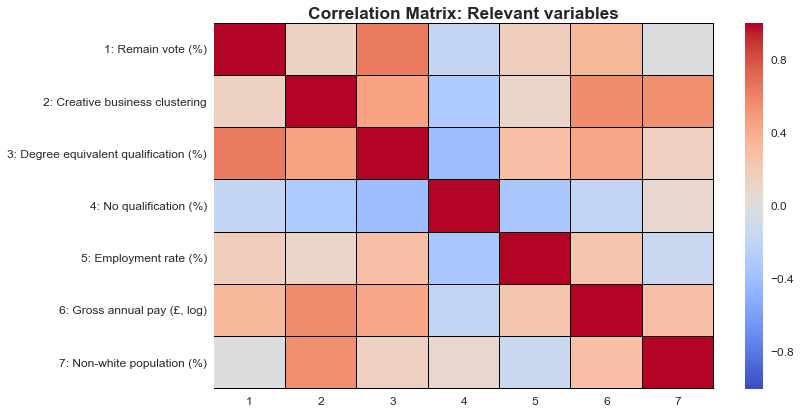

In [30]:
#Plot heatmap of the correlation matrix
#Create heatmap
data['ashe_annual_pay_gross_logged'] = np.log(data.ashe_annual_pay_gross+0.0001)

vars_heatmap = ['remain_rate','ci_biz_lq','aps_nvq4_pc', 'aps_no_qual_pc','aps_emp_rate_pc',
                'ashe_annual_pay_gross_logged','non_white_pc']
heatmap_mat = data[vars_heatmap].corr()

plt.figure(figsize=(12,6))

#Labels
y_labels = ['1: Remain vote (%)','2: Creative business clustering','3: Degree equivalent qualification (%)',
           '4: No qualification (%)','5: Employment rate (%)','6: Gross annual pay (£, log)','7: Non-white population (%)']
x_labels=list(range(1,8))

#Set style
sns.set(font_scale=1.2)
sns.heatmap(heatmap_mat,cmap="coolwarm",yticklabels=y_labels,xticklabels=x_labels,
            linecolor='black',linewidths=0.005)
plt.title("Correlation Matrix: Relevant variables",
         fontdict={
        'fontsize': 'large', 'fontweight':'bold'})

plt.tight_layout()

plt.savefig("viz_outputs/correlation_matrix.pdf")


## 3. Econometric analysis
Tasks
* Load TTWA geo data
* Calculate spatial autocorrelation in the data
* Model remain outcomes and report
* Calculate creative employment as share of remain voting to explore mechanisms underpinning the relationship.

In [31]:
#Get Shapefile here:
#https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip
#Load shapefile
ttwa_shp = pysal.open("data/TTWA_2011_UK_BGC_V3.shp")

In [51]:
#Read shapefile weights and attributes
#And attributes
w = pysal.rook_from_shapefile("data/TTWA_2011_UK_BGC_V3.shp")
attr = pysal.open("data/TTWA_2011_UK_BGC_V3.dbf")

#Remove from data those ttwas with missing values
#data_completes = data[[str(x)!='nan' for x in list(data['ttwa_name'])]]

data_completes = data.dropna()

#Merge with shapefile attributes for ordering
data_ord = pd.merge(pd.DataFrame(attr.by_col['TTWA11CD'],columns=['TTWA11CD']),
                   data_completes,left_on='TTWA11CD',right_on='ttwa_code',how='outer',sort=False)

#Create df with only complete TTWAS and remove those from the weights
data_ord_completes = data_ord[[str(x)!="nan" for x in data_ord.ttwa_code]]
ttwas_w_data = list(data_ord_completes.index)

#Subset weights to focus on available TTWAs, and normalise
wsub = pysal.w_subset(w,ttwas_w_data)
wsub.transform='r'

Island ids:  [9, 166, 167, 168, 169]
Island id:  [9]


In [33]:
#Run OLS with spatial diagnostics.

y = np.array(data_ord_completes.remain_rate)
y.resize(len(y),1)

#pred = pd.Series(scipy.stats.mstats.zscore(data_ord_completes['ci_biz_lq']),
#                 index=data_ord_completes.index)

x_vars = ['ci_biz_lq','aps_nvq4_pc','aps_econ_rate_pc','ashe_annual_pay_gross','non_white_pc']

x_norm = data_ord_completes[x_vars].apply(lambda x: zscore(x))

reg_vars = pd.get_dummies(data_ord_completes.region,prefix="region")

x_vars_all = x_vars + list(reg_vars.columns[1:])

x = np.array(pd.concat([x_norm,reg_vars.iloc[:,1:]],axis=1))

ols = pysal.spreg.ols.OLS(y,x,wsub,moran=True,spat_diag=True,name_y='remain',name_x=x_vars_all,robust='white')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      remain                Number of Observations:         171
Mean dependent var  :      0.4597                Number of Variables   :          16
S.D. dependent var  :      0.0823                Degrees of Freedom    :         155
R-squared           :      0.8329
Adjusted R-squared  :      0.8167
Sum squared residual:       0.192                F-statistic           :     51.5074
Sigma-square        :       0.001                Prob(F-statistic)     :   2.582e-52
S.E. of regression  :       0.035                Log likelihood        :     337.892
Sigma-square ML     :       0.001                Akaike info criterion :    -643.783
S.E of regression ML:      0.0335                Schwarz criterion     :    -593.517

White Standard Errors
-------------------------------------------------------

In [62]:
#Generate output
output_table =pd.DataFrame([{'Variable':v,
              'Coefficient':np.round(c[0],3),
              'Standard Error':np.round(s,3),
              'p-value':np.round(p[1],3)} for v,c,s,p in zip(ols.name_x,ols.betas,ols.std_err,ols.t_stat)])
output_table2 = output_table[['Variable','Coefficient','Standard Error','p-value']]
output_table2.Coefficient = [str(c)+"***" if p<0.001 
                             else str(c)+"**" if p<0.05 
                             else str(c)+"*" if p<0.01
                             else str(c) for c,p in zip(output_table2.Coefficient,output_table2['p-value'])]
output_table2.to_csv("data_outputs/reg_table.csv")

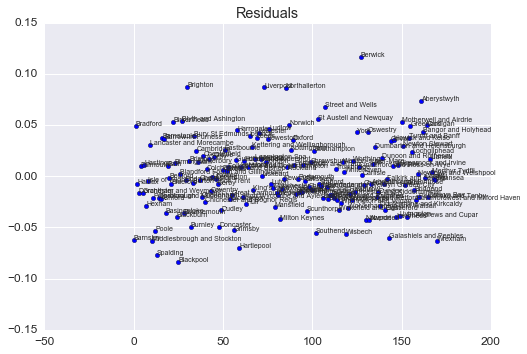

In [63]:
plt.scatter(range(len(ols.u)),ols.u)
plt.title("Residuals")
for h,v,t in zip(range(len(ols.u)),ols.u,data_ord_completes['ttwa_name']):
    plt.annotate(s=t,xy=(h,v),size=7)
diags = pd.DataFrame({'ttwa':data_ord_completes.ttwa_name,
              'act':data_ord_completes.remain_rate,
              'pred':[p[0] for p in ols.predy],
             'res':[r[0] for r in ols.u]})

In [180]:
#Model controlling for spatial autocorrelation
gm_mod = pysal.spreg.ml_error.ML_Error(y, x, wsub, vm=False, name_y='remain', 
                                       name_x=x_vars_all)

/usr/local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:596: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [181]:
print(gm_mod.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      remain                Number of Observations:         171
Mean dependent var  :      0.4597                Number of Variables   :          16
S.D. dependent var  :      0.0823                Degrees of Freedom    :         155
Pseudo R-squared    :      0.8316
Sigma-square ML     :       0.001                Log likelihood        :     340.534
S.E of regression   :       0.033                Akaike info criterion :    -649.069
                                                 Schwarz criterion     :    -598.802

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [110]:
above_1_sd_pc = 100*np.sum(zscore(data_ord_completes['ci_biz_lq'])>1)/len(data_ord_completes)

"%.2f"%above_1_sd_pc + "%" + " " + "clusters are one standard deviation above the mean"


'12.87% clusters are one standard deviation above the mean'

In [75]:
#Models with winsorised variables
y = np.array(winsorize(data_ord_completes.remain_rate))
y.resize(len(y),1)

#pred = pd.Series(scipy.stats.mstats.zscore(data_ord_completes['ci_biz_lq']),
#                 index=data_ord_completes.index)

x_vars = ['ci_biz_lq','aps_nvq4_pc','aps_econ_rate_pc','ashe_annual_pay_gross','non_white_pc']

x_norm = data_ord_completes[x_vars].apply(lambda x: zscore(winsorize(x)))

reg_vars = pd.get_dummies(data_ord_completes.region,prefix="region")

x_vars_all = x_vars + list(reg_vars.columns[1:])

x = np.array(pd.concat([x_norm,reg_vars.iloc[:,1:]],axis=1))

ols_win = pysal.spreg.ols.OLS(y,x,wsub,moran=True,spat_diag=True,name_y='remain',name_x=x_vars_all,robust='white')
print(ols_win.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      remain                Number of Observations:         171
Mean dependent var  :      0.4595                Number of Variables   :          16
S.D. dependent var  :      0.0808                Degrees of Freedom    :         155
R-squared           :      0.8261
Adjusted R-squared  :      0.8093
Sum squared residual:       0.193                F-statistic           :     49.0876
Sigma-square        :       0.001                Prob(F-statistic)     :   5.403e-51
S.E. of regression  :       0.035                Log likelihood        :     337.571
Sigma-square ML     :       0.001                Akaike info criterion :    -643.143
S.E of regression ML:      0.0336                Schwarz criterion     :    -592.876

White Standard Errors
-------------------------------------------------------

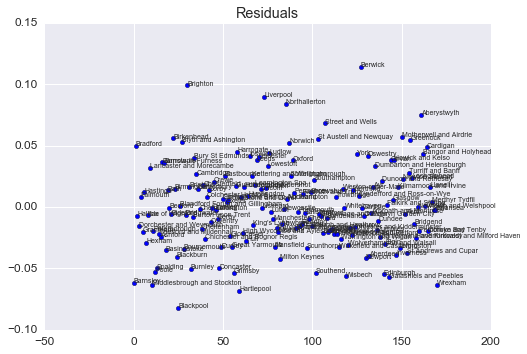

In [76]:
plt.scatter(range(len(ols_win.u)),ols_win.u)
plt.title("Residuals")
for h,v,t in zip(range(len(ols_win.u)),ols_win.u,data_ord_completes['ttwa_name']):
    plt.annotate(s=t,xy=(h,v),size=7)